In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/household_power_consumption.txt', sep=';', skiprows=[15923, 48395, 97195, 146194, 194902, 227677])
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260350 entries, 0 to 260349
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Date                   260350 non-null  object 
 1   Time                   260349 non-null  object 
 2   Global_active_power    260349 non-null  object 
 3   Global_reactive_power  260348 non-null  object 
 4   Voltage                260348 non-null  object 
 5   Global_intensity       260347 non-null  object 
 6   Sub_metering_1         260346 non-null  object 
 7   Sub_metering_2         260346 non-null  object 
 8   Sub_metering_3         260331 non-null  float64
dtypes: float64(1), object(8)
memory usage: 17.9+ MB


In [4]:
df.isnull().sum()

Date                      0
Time                      1
Global_active_power       1
Global_reactive_power     2
Voltage                   2
Global_intensity          3
Sub_metering_1            4
Sub_metering_2            4
Sub_metering_3           19
dtype: int64

In [5]:
df.dropna(inplace=True)
df.isnull().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260331 entries, 0 to 260348
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Date                   260331 non-null  object 
 1   Time                   260331 non-null  object 
 2   Global_active_power    260331 non-null  object 
 3   Global_reactive_power  260331 non-null  object 
 4   Voltage                260331 non-null  object 
 5   Global_intensity       260331 non-null  object 
 6   Sub_metering_1         260331 non-null  object 
 7   Sub_metering_2         260331 non-null  object 
 8   Sub_metering_3         260331 non-null  float64
dtypes: float64(1), object(8)
memory usage: 19.9+ MB


In [7]:
df['Global_intensity'] = df['Global_intensity'].astype('float') 

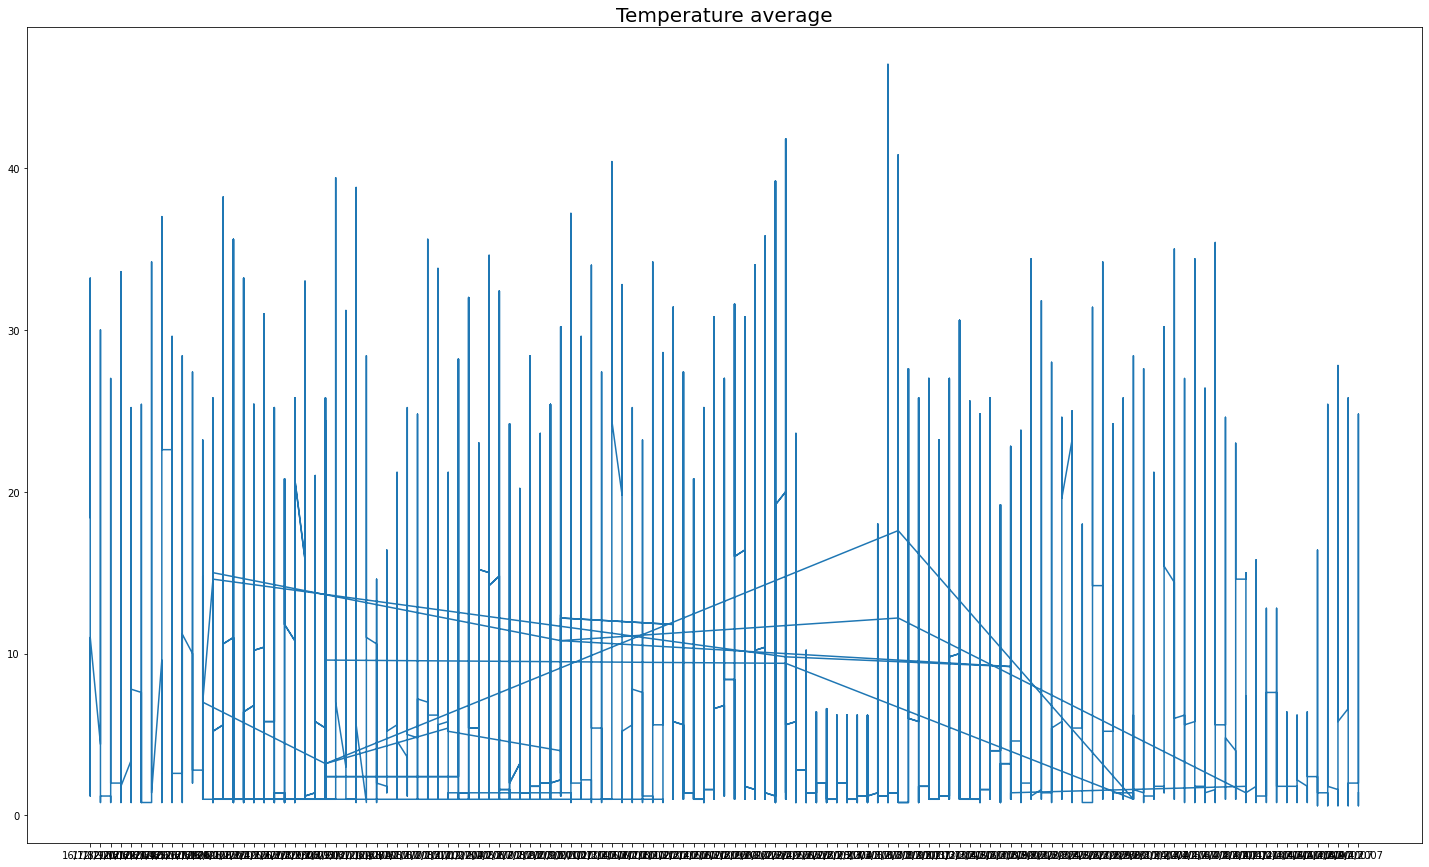

In [8]:
dates = df['Date'].values
temp  = df['Global_intensity'].values
 
 
plt.figure(figsize=(25,15))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20);

In [9]:
# membagi data test dan data train

from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(temp, test_size=0.2)

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [11]:
train_set = windowed_dataset(data_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(data_test, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [12]:
# Penggunaan Callbacks

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < 4.1):
      print("\nMAE telah mencapai < 10% dari total data")
      self.model.stop_training = True
callbacks = myCallback()

In [13]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=30, validation_data = test_set, callbacks=[callbacks])

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

2083/2083 [==============================] - 221s 106ms/step - loss: 3.8366 - mae: 4.3201 - val_loss: 3.6994 - val_mae: 4.1844
Epoch 2/30
2083/2083 [==============================] - 228s 109ms/step - loss: 3.6840 - mae: 4.1723 - val_loss: 3.6970 - val_mae: 4.1811
Epoch 3/30
2083/2083 [==============================] - 230s 110ms/step - loss: 3.6815 - mae: 4.1689 - val_loss: 3.6944 - val_mae: 4.1777
Epoch 4/30
2083/2083 [==============================] - 229s 110ms/step - loss: 3.6793 - mae: 

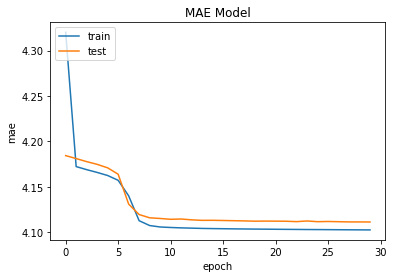

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

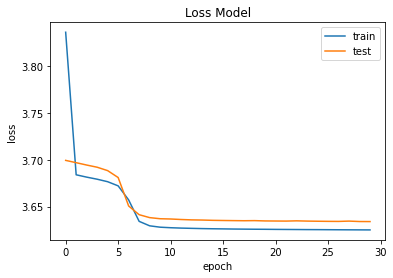

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()